### Analyzing a Facebook Page's Posts

The goal of this notebook is to analyze the last 300 posts for a specified Facebook page.

Using the [Facepy library](https://github.com/jgorset/facepy "github repo") to access Facebook's [Graph API](https://developers.facebook.com/docs/graph-api "API reference guide"), the data from the following fields is collected into a standard Python list:

- Object ID (serves as a unique identifier for each post)
- Name
- Message
- Likes (count)
- Total Reactions (count)

The list is then pickled into a file for persistance and offline analysis. 

To begin the analysis, the data is loaded from the file into a [Pandas](http://pandas.pydata.org/) DataFrame. 

There are 2 parts to the analysis:

- Create a [Seaborn](http://seaborn.pydata.org/) stacked bar chart visualization to see how many likes vs total reations each of the 300 posts received on Facebook. Do any posts stand out as far more popular than their peers?

- Use the [TextBlob](https://textblob.readthedocs.io/en/latest/) library to run sentiment analysis on the posts and classify them as positive or negative 

This notebook is designed with Python 2.7. Verify the version below:

In [1]:
import sys
print (sys.version)

2.7.12 |Anaconda 4.2.0 (64-bit)| (default, Jun 29 2016, 11:07:13) [MSC v.1500 64 bit (AMD64)]


You may also want to verify the following packages are installed in your environment:
- Jupyter Notebook 4.2.3
- Facepy 1.0.8
- Spacy 1.2.0
- Seaborn 0.7.1
- Pandas 0.19.1

In [2]:
import cPickle
import requests
import pandas as pd
import seaborn as sns
from facepy import GraphAPI
import matplotlib as mpl

from matplotlib import pyplot as plt
from textblob import TextBlob

In [3]:
%matplotlib inline

### Facebook API Config

Enter your Facebook access token below. 

You can get a fresh access token from top of this page:
https://developers.facebook.com/tools/explorer

In [4]:
access_token = ""

Enter the page you want to analyze, for example to analyze the news media page for AJ+ on Facebook:

In [5]:
page_to_analyze = "ajplusenglish"

Initialize a Facepy graph object with the access_token:

In [6]:
graph = GraphAPI(access_token)

FacePy Documentation: https://facepy.readthedocs.io/en/latest/usage/graph-api.html

### Get last 300 posts on page to analyze

Note that the "{page-id}/posts" endpoint used below shows only the posts that were published by this page (including links and status updates).

Full API reference for /posts:
https://developers.facebook.com/docs/graph-api/reference/v2.8/page/feed

In [7]:
# This will return a generator type w/ 100 posts in each page
posts = graph.get(page_to_analyze + '/posts', page=True, limit=25)  #could change to /feed

In [8]:
type(posts)

generator

In [9]:
# Create a list to hold the last 300 posts
posts_300 = []

# Run loop 12 times, getting 25 posts each time, 300 total
for i in range(12):
    posts_temp_25 = posts.next()
    posts_300 = posts_300 + posts_temp_25[u'data']

Verify that 300 posts were collected:

In [10]:
len(posts_300)

300

Which fields were collected for the first post # 0?

In [11]:
posts_300[0].keys()

[u'picture',
 u'is_hidden',
 u'likes',
 u'from',
 u'name',
 u'privacy',
 u'is_expired',
 u'comments',
 u'actions',
 u'properties',
 u'source',
 u'link',
 u'object_id',
 u'shares',
 u'created_time',
 u'message',
 u'updated_time',
 u'type',
 u'id',
 u'status_type',
 u'icon']

In [12]:
#What is the message field?
posts_300[0][u'message']

u'After 6 years, the UN finally says sorry for spreading cholera in Haiti...but not for causing the outbreak.'

Save the list to a 5 - 6 MB file on disk for offline analysis:

In [13]:
cPickle.dump(posts_300, open('posts_300.p', 'wb')) 

In [14]:
# Read the saved file back
posts_300_disk = cPickle.load(open('posts_300.p', 'rb'))

### Make a Pandas Dataframe

Before creating a DataFrame with 5 columns from the list, inspect the relevant 5 fields by printing them out.

Here we print the 5 fields in the list for the 7th post:

In [15]:
# DF Col-1
posts_300_disk[7][u'id']

u'407570359384477_848862495255259'

In [16]:
# DF Col-2

# If the post does not have a name field, place a KeyError in the cell
try:
    print posts_300_disk[9][u'name']
except KeyError, e:
    print 'KeyError-reason: "%s"' % str(e)

An Unusual Gold Heist


In [17]:
# DF Col-3
posts_300_disk[9][u'message']

u'This man literally struck gold when he stole a bucket full of gold flakes in broad daylight. Now the NYPD is after him and the $1.6M worth of gold.'

### Get likes count

In [18]:
#DF Col-4
r = requests.get("https://graph.facebook.com/v2.8/" + str(posts_300_disk[9][u'id']) + "/likes?summary=true&access_token=" + access_token)
r.json()[u'summary'][u'total_count']

8599

### Get Reactions count

In [19]:
#DF Col-5
r = requests.get("https://graph.facebook.com/v2.8/" + str(posts_300_disk[9][u'id']) + "/reactions?summary=true&access_token=" + access_token)
r.json()[u'summary'][u'total_count']

14150

### First make an empty DataFrame w/ 300 rows

In [20]:
col = ['id', 'name', 'message', 'likes_count', 'reactions_count']

In [21]:
df = pd.DataFrame(columns=col, index=range(0,300))

In [22]:
df.head(3)

,id,name,message,likes_count,reactions_count
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN


### Loop through the list once and extract out 5 cols from each post to insert to a DataFrame row

In [23]:
# This loop prints a counter in increments of 25 as it gathers the likes_count and reactions_count information for all 300 posts by making HTTP request calls

print("This counter will increment from 0 - 300 to show you the progress: ")

counter = 0
for post in posts_300_disk:
    
    # Get ID
    current_id = post[u'id']
    
    # Get Name
    try:
        current_name = post[u'name']
    except KeyError, e:
        current_name = 'KeyError-reason: "%s"' % str(e)
    
    # Get Message
    try:
        current_message =  post[u'message']
    except KeyError, e:
        current_message = 'KeyError-reason: "%s"' % str(e)
    
    # Get Likes
    r = requests.get("https://graph.facebook.com/v2.8/" + str(post[u'id']) + "/likes?summary=true&access_token=" + access_token)
    current_likes = r.json()[u'summary'][u'total_count']
    
    # Get Reactions
    r = requests.get("https://graph.facebook.com/v2.8/" + str(post[u'id']) + "/reactions?summary=true&access_token=" + access_token)
    current_reactions = r.json()[u'summary'][u'total_count']
    
    # For debugging purposes
    #print(str(counter) + ":" + str(current_id) + ":" + str(current_name) + ":" + str(current_message) + ":" + str(current_likes) + ":" + str(current_reactions))
    
    # Populate each DataFrame row with the current data in the loop interation
    df.iloc[counter] = pd.Series({col[0]: current_id,
                            col[1]: current_name,
                            col[2]: current_message,
                            col[3]: current_likes,
                            col[4]: current_reactions})
    
    # Print & Increment counter
    if counter % 25 == 0:
        print("Status: " + str(counter))
    
    counter = counter + 1
    
print("Loop successfully completed!")

This counter will increment from 0 - 300 to show you the progress: 
Status: 0
Status: 25
Status: 50
Status: 75
Status: 100
Status: 125
Status: 150
Status: 175
Status: 200
Status: 225
Status: 250
Status: 275
Loop successfully completed!


Display the first 3 rows of the fully populated DataFrame:

In [24]:
df.head(3)

,id,name,message,likes_count,reactions_count
0,407570359384477_849380761870099,Cameroon's Hair Salons Are Helping Fight Again...,Hair salons in Cameroon are saving lives as ou...,926,1059
1,407570359384477_849292098545632,#NoDAPL Launches #BankExit Divestment Campaign,Will #BankExit pull the plug on the $10.5 bill...,1542,1797
2,407570359384477_849233215218187,Trump “Thank You” Tour,"We're live in Cincinnati, Ohio where President...",1060,5363


In [25]:
# What is the average # of likes for each post?
df["likes_count"].mean()

9603.9633333333331

In [26]:
# What is the average # of reactions for each post?
df["reactions_count"].mean()

15200.040000000001

### Create a stacked bar chart visualization showing the likes + reactions for each post

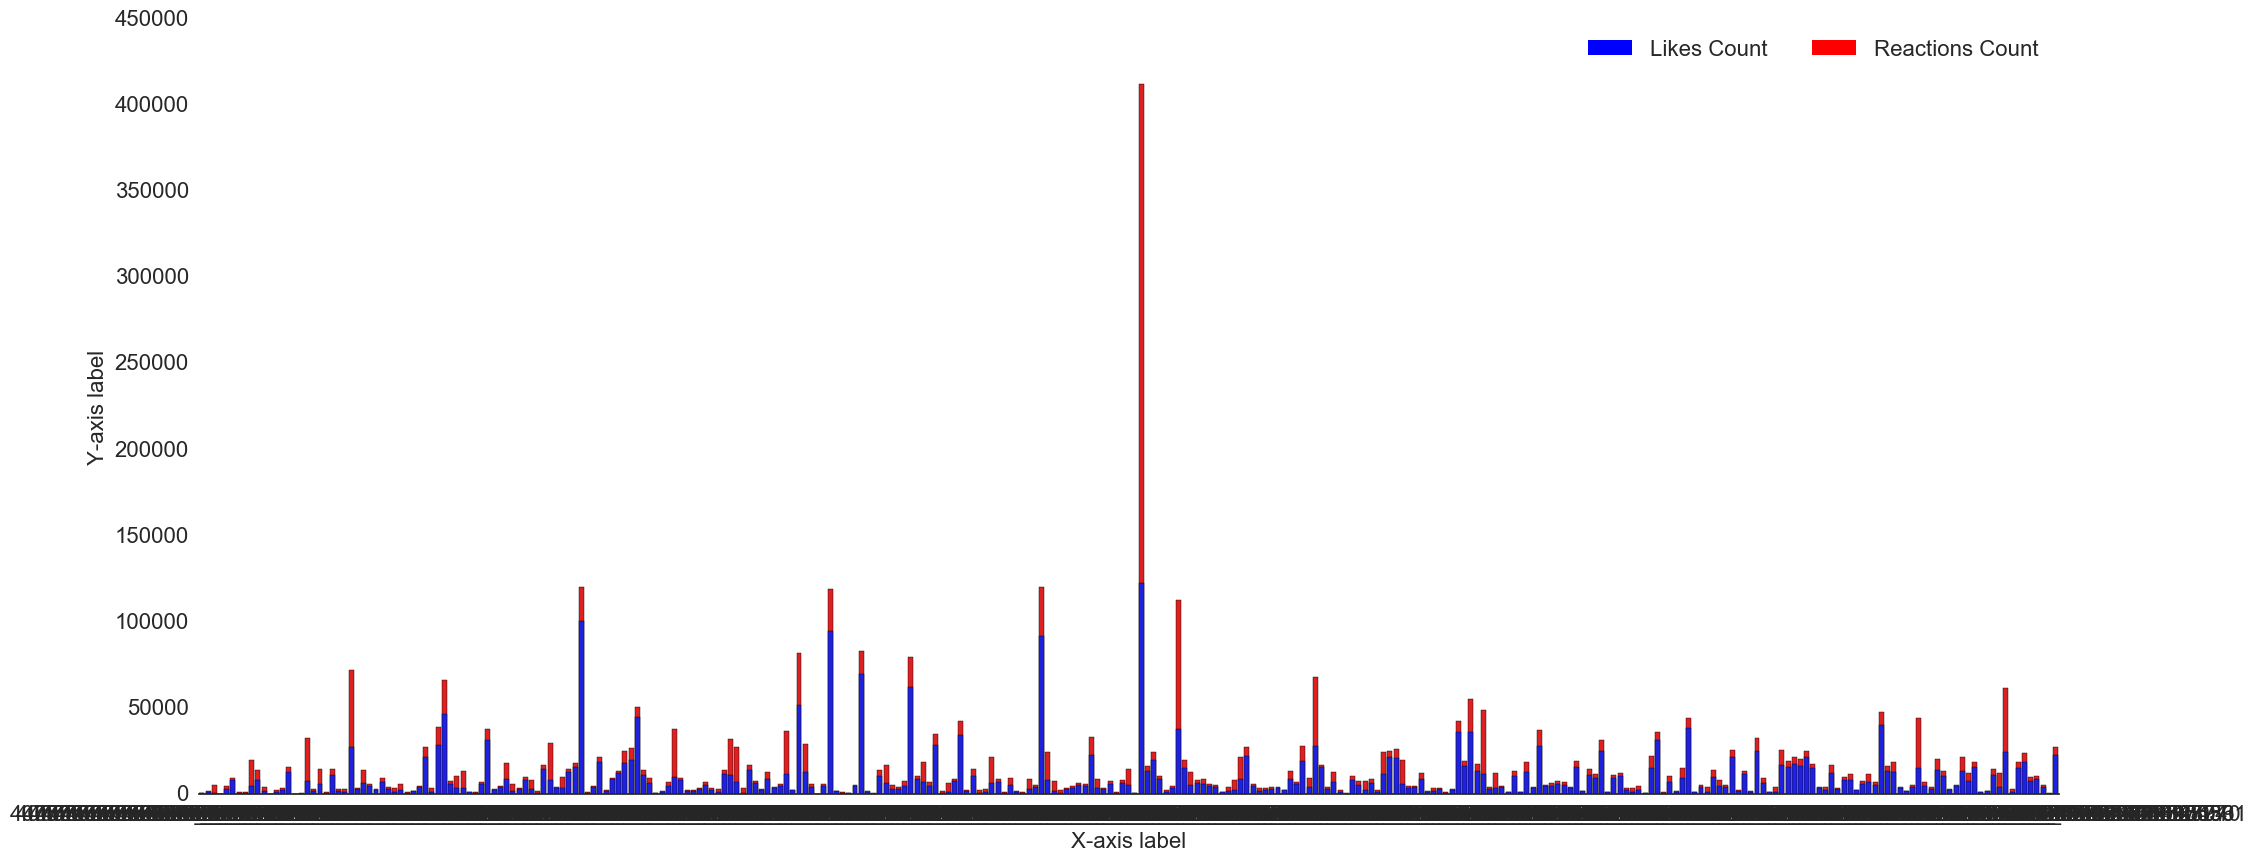

In [27]:
# Code referenced from: http://randyzwitch.com/creating-stacked-bar-chart-seaborn/

# Read in data & create total column
stacked_bar_data = df
stacked_bar_data["total"] = stacked_bar_data['reactions_count']

#Set general plot properties
sns.set_style("white")
sns.set_context({"figure.figsize": (24, 10)})

#Plot 1 - background - "total" (top) series
sns.barplot(x = stacked_bar_data['id'], y = stacked_bar_data['total'], color = "red")

#Plot 2 - overlay - "bottom" series
bottom_plot = sns.barplot(x = stacked_bar_data['id'], y = stacked_bar_data['likes_count'], color = "blue")


topbar = plt.Rectangle((0,0),1,1,fc="red", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='blue',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['Likes Count', 'Reactions Count'], loc=1, ncol = 2, prop={'size':16})
l.draw_frame(False)

#Optional code - Make plot look nicer
sns.despine(left=True)
bottom_plot.set_ylabel("Y-axis label")
bottom_plot.set_xlabel("X-axis label")

#Set fonts to consistent 16pt size
for item in ([bottom_plot.xaxis.label, bottom_plot.yaxis.label] +
           bottom_plot.get_xticklabels() + bottom_plot.get_yticklabels()):
  item.set_fontsize(16)

There appears to be one post that got significantly more reactions than any other (in the middle of the x-axis). 

Which post was it?

In [28]:
df[df['reactions_count'] >= 400000]

,id,name,message,likes_count,reactions_count,total
151,407570359384477_840945559380286,Child Panics after Chlorine Gas Attack,"“Will I die, miss? Will I die?” This child in ...",122802,412534,412534


In the bar chart, there appears to be another tier of posts that got over 100k reations.

Which posts were they?

In [30]:
df[df['reactions_count'] >= 100000].sort_values(by=['reactions_count'], ascending=[False])

,id,name,message,likes_count,reactions_count,total
151,407570359384477_840945559380286,Child Panics after Chlorine Gas Attack,"“Will I die, miss? Will I die?” This child in ...",122802,412534,412534
135,407570359384477_841734352634740,Joe Biden Is VP Goals,Obama may be America's cool dad but let's be h...,92020,120450,120450
61,407570359384477_842229522585223,"KeyError-reason: ""u'name'""",Ever wanted to sleep with the fish? This under...,100396,120447,120447
101,407570359384477_843241355817373,Amazon's Ad,The Muslim imam and Christian priest from Amaz...,94791,119019,119019
157,407570359384477_839933059481536,Don't Forget Aleppo.,"Crying nurses, mourning fathers: Aleppo's been...",38223,112934,112934


KeyErrors may appear in the name field. How many unique names are there?

In [31]:
len(df['name'].unique())

263

How many posts don't have a name field?

In [32]:
df_filtered = df[df['name'] == '''KeyError-reason: "u'name'"''']

In [33]:
len(df_filtered.index)

9

In [34]:
# Display all posts with a missing name field

df_filtered.head(10)

,id,name,message,likes_count,reactions_count,total
61,407570359384477_842229522585223,"KeyError-reason: ""u'name'""",Ever wanted to sleep with the fish? This under...,100396,120447,120447
129,407570359384477_842225375918971,"KeyError-reason: ""u'name'""",Donald Trump outlined what he'll do on day one...,890,1262,1262
156,407570359384477_838676092940566,"KeyError-reason: ""u'name'""","At about 1,100 pounds, Juan Pedro might be the...",3642,4595,4595
203,407570359384477_838247216316787,"KeyError-reason: ""u'name'""",The Dead Sea is shrinking. So these activists ...,16686,19304,19304
222,407570359384477_837682236373285,"KeyError-reason: ""u'name'""",Meet the boxer knocking some sense into young ...,1857,2100,2100
261,407570359384477_836333119841530,"KeyError-reason: ""u'name'""",Los Angeles Police arrest anti-Trump protesters,2563,3972,3972
265,407570359384477_836153803192795,"KeyError-reason: ""u'name'""",Anti-Trump Protesters in Union Square,8257,11837,11837
269,407570359384477_836016609873181,"KeyError-reason: ""u'name'""",Thousands Protest in NYC below Trump Tower,5595,7189,7189
279,407570359384477_835443899930452,"KeyError-reason: ""u'name'""",NYC protest at Trump Tower,13963,20687,20687


### Classify the posts as positive or negative sentiment

First test the TextBlob package's sentiment polarity method with a positive and negative phrase:

In [35]:
happy = TextBlob("I am so happy joy cheerful good upbeat joyful glad up")
happy.sentiment.polarity

0.64

In [36]:
sad = TextBlob("I am so angry sad furious depressed negative")
sad.sentiment.polarity

-0.43333333333333335

So, positive posts have positive #s, between 0 - 1.

Negative posts have negative #s, between -1 and 0.

In [37]:
# Create a list to store the polarity data for the 300 post's messages
polarity = []

# For each row in the df, generate a new polarity column
for msg in df['message']:
    polarity.append(TextBlob(msg).sentiment.polarity)
    
df['polarity'] = polarity

In [38]:
df.head(10)

,id,name,message,likes_count,reactions_count,total,polarity
0,407570359384477_849380761870099,Cameroon's Hair Salons Are Helping Fight Again...,Hair salons in Cameroon are saving lives as ou...,926,1059,1059,0.000000
1,407570359384477_849292098545632,#NoDAPL Launches #BankExit Divestment Campaign,Will #BankExit pull the plug on the $10.5 bill...,1542,1797,1797,0.000000
2,407570359384477_849233215218187,Trump “Thank You” Tour,"We're live in Cincinnati, Ohio where President...",1060,5363,5363,0.068182
3,407570359384477_848366171971558,Subscribe to Newsbroke,Uggggggh the world ... Subscribe to Newsbroke ...,75,78,78,0.375000
4,407570359384477_849219301886245,You Have No Privacy,The UK just made it legal for the government t...,3072,4698,4698,0.064286
5,407570359384477_849186268556215,Trevor Noah and Tomi Lahren Face Off,Tomi Lahren compared Black Lives Matter to the...,8056,9640,9640,-0.166667
6,407570359384477_849128968561945,Cuba and U.S. React to Fidel's Life and Death,People in Havana and Miami have very different...,898,1078,1078,0.000000
7,407570359384477_848862495255259,Mosques Under Threat,Threatening letters are still showing up at mo...,650,1517,1517,0.000000
8,407570359384477_848905478584294,Child Malnutrition in Yemen,More than 1.5 million children are starving in...,4951,20011,20011,0.500000
9,407570359384477_848840348590807,An Unusual Gold Heist,This man literally struck gold when he stole a...,8601,14152,14152,0.237500


In [39]:
# How many posts are positive?
len(df[df['polarity'] > 0].index)

105

In [40]:
# How many posts are negative?
len(df[df['polarity'] < 0].index)

72

In [41]:
# How many posts are unclassified?
len(df[df['polarity'] == 0].index)

123

In [42]:
# What are the most positive post messages?
df[df['polarity'] > 0.7]

,id,name,message,likes_count,reactions_count,total,polarity
15,407570359384477_848350815306427,Subscribe to Newsbroke,"If Newsbroke gets to 10k subscribers, then we'...",421,462,462,0.871931
44,407570359384477_846626858812156,Amateurs Trying to Fly,If you think you can fly ... you can't. These ...,1025,1505,1505,0.800000
277,407570359384477_835438653264310,RIP Leonard Cohen,The legendary poet and singer who composed “Ha...,5032,7443,7443,1.000000


In [43]:
# What are the most negative post messages?
df[df['polarity'] < -0.8]

,id,name,message,likes_count,reactions_count,total,polarity
10,407570359384477_848324461975729,Coral Reefs Are Dying,Bad news: This is the worst coral die-off ever...,1692,4404,4404,-0.85
183,407570359384477_839115999563242,Make America Hate Again,Has America learned to hate again? Hate crimes...,1465,2542,2542,-0.80
242,407570359384477_837119286429580,ISIS Blast at Pakistan Sufi Shrine,This mother had to go through a parent's worst...,1377,4005,4005,-1.00
